In [102]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]

True
using device: cuda


In [103]:
from mcg_ae_mae import AE, compute_loss, train_step

In [104]:
# read in original data and base imputation methods data
adata = sc.read_h5ad("mcg_210505_5618x670.h5ad")
zdata = sc.read_h5ad("mcg_210505_5618x670_zero_imputation.h5ad")
mdata = sc.read_h5ad("mcg_210505_5618x670_mean_imputation.h5ad")
kdata = sc.read_h5ad("mcg_210505_5618x670_knn_imputation.h5ad")

In [105]:
# get mask to impute values with coverage <5
mask = pd.read_parquet("mask.parquet")
mask.head(2)

geneslop2k                             PRKCZ  ENSG00000157933.11  PRDM16  \
20210505-UMB5577-preAb-PFC-A09-L1_A1    True                True    True   
20210505-UMB5577-preAb-PFC-A09-L1_A10   True                True    True   

geneslop2k                             ENSG00000162591.17  ENSG00000171735.20  \
20210505-UMB5577-preAb-PFC-A09-L1_A1                 True                True   
20210505-UMB5577-preAb-PFC-A09-L1_A10                True                True   

geneslop2k                             ENSG00000142599.20  CASZ1  KAZN  \
20210505-UMB5577-preAb-PFC-A09-L1_A1                 True   True  True   
20210505-UMB5577-preAb-PFC-A09-L1_A10                True   True  True   

geneslop2k                             IGSF21  EPHB2  ...  EFCAB6  PARVB  \
20210505-UMB5577-preAb-PFC-A09-L1_A1     True   True  ...    True   True   
20210505-UMB5577-preAb-PFC-A09-L1_A10    True   True  ...    True   True   

geneslop2k                             PRR5-ARHGAP8  PHF21B  CELSR1  GRAMD4  \
20210505-UMB5577-preAb-PFC-A09-L1_A1           True    True    True    True   
20210505-UMB5577-preAb-PFC-A09-L1_A10          True    True    True    True   

geneslop2k                             TBC1D22A  ENSG00000224271.8  TAFA5  \
20210505-UMB5577-preAb-PFC-A09-L1_A1       True               True   True   
20210505-UMB5577-preAb-PFC-A09-L1_A10      True               True   True   

geneslop2k                             ENSG00000188511.14  
20210505-UMB5577-preAb-PFC-A09-L1_A1                 True  
20210505-UMB5577-preAb-PFC-A09-L1_A10                True  

[2 rows x 670 columns]

In [106]:
# get random dropout mask for evaluation metrics
dropout_mask = pd.read_parquet("dropout_mask.parquet")
dropout_mask.head(2)

geneslop2k                             PRKCZ  ENSG00000157933.11  PRDM16  \
20210505-UMB5577-preAb-PFC-A09-L1_A1   False               False   False   
20210505-UMB5577-preAb-PFC-A09-L1_A10  False               False   False   

geneslop2k                             ENSG00000162591.17  ENSG00000171735.20  \
20210505-UMB5577-preAb-PFC-A09-L1_A1                False               False   
20210505-UMB5577-preAb-PFC-A09-L1_A10               False               False   

geneslop2k                             ENSG00000142599.20  CASZ1   KAZN  \
20210505-UMB5577-preAb-PFC-A09-L1_A1                False  False  False   
20210505-UMB5577-preAb-PFC-A09-L1_A10               False  False  False   

geneslop2k                             IGSF21  EPHB2  ...  EFCAB6  PARVB  \
20210505-UMB5577-preAb-PFC-A09-L1_A1    False  False  ...   False  False   
20210505-UMB5577-preAb-PFC-A09-L1_A10   False  False  ...   False  False   

geneslop2k                             PRR5-ARHGAP8  PHF21B  CELSR1  GRAMD4  \
20210505-UMB5577-preAb-PFC-A09-L1_A1          False   False   False   False   
20210505-UMB5577-preAb-PFC-A09-L1_A10         False   False   False   False   

geneslop2k                             TBC1D22A  ENSG00000224271.8  TAFA5  \
20210505-UMB5577-preAb-PFC-A09-L1_A1      False              False  False   
20210505-UMB5577-preAb-PFC-A09-L1_A10     False              False  False   

geneslop2k                             ENSG00000188511.14  
20210505-UMB5577-preAb-PFC-A09-L1_A1                False  
20210505-UMB5577-preAb-PFC-A09-L1_A10                True  

[2 rows x 670 columns]

In [107]:
# set xdata to the base imputation method data to push through autoencoder
xdata = kdata

In [108]:
# set X as data
X = xdata.to_df().astype("float32")

# convert to tensors so readable to computer during training
X = torch.tensor(X.values).to(device)

X.shape, X.shape[1]

(torch.Size([5618, 670]), 670)

## check that everything went in properly

In [109]:
# create dataframe
methyl_df = xdata.to_df()
# check for na's
methyl_df.isna().sum().sum() # should be 0

np.int64(0)

In [110]:
# check that coverage mask is correct
methyl_df = methyl_df[mask]
methyl_df.isna().sum().sum() # should be 102112

np.int64(102112)

In [111]:
# check that dropout mask is correct
methyl_df = methyl_df[~dropout_mask]
methyl_df.isna().sum().sum() # should be 285017

np.int64(285017)

In [112]:
# check that range of data is [-1, 1]
xdata.to_df().min().min(), xdata.to_df().max().max()

(-1.0, 1.0)

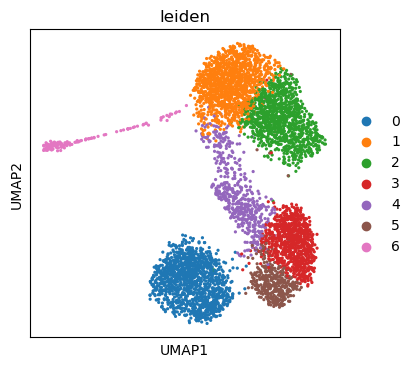

In [113]:
# visualize leiden clusters on umap
sc.pl.umap(xdata, color="leiden")

## Train Model

In [114]:
# initialize model & optimizer
model = AE(input_dim=X.shape[1], hidden_dim=64, latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [115]:
# load data into batches
from torch.utils.data import Dataset, DataLoader

class AutoencoderDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index].to(device)
    
dataset = AutoencoderDataset(X)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [116]:
%%time

# training loop
epochs = 1000
loss_hist = [] # initialize empty loss history list
no_improve_counter = 0 # initialize no improvement counter at 0
patience = 20
min_decrease = 0.000001
best_loss = float("inf") # initialize best loss at infinity

for epoch in range(epochs):
    epoch_loss = 0.0 # initialize epoch loss accumulator at 0
 
    for data in dataloader:
        loss = train_step(model, data, optimizer)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    loss_hist.append(avg_epoch_loss)
    
    if avg_epoch_loss < best_loss - min_decrease:
        best_loss = avg_epoch_loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        
    if no_improve_counter >= patience:
        print(f"early stopping at epoch {epoch + 1}, avg loss: {avg_epoch_loss:.6f}")
        break
        
    if epoch % 100 == 0:
        print(f"epoch {epoch + 1}, avg loss: {avg_epoch_loss:.6f}")

epoch 1, avg loss: 0.275871
epoch 101, avg loss: 0.086000
epoch 201, avg loss: 0.084523
early stopping at epoch 262, avg loss: 0.084276
CPU times: user 45.6 s, sys: 516 ms, total: 46.1 s
Wall time: 46.1 s


## Generate Data

In [117]:
ae_imp = pd.DataFrame(model.inference(X.to(device)).detach().cpu().numpy(), index=adata.to_df().index, columns=adata.to_df().columns)
ae_imp.head(2)

geneslop2k                                PRKCZ  ENSG00000157933.11    PRDM16  \
20210505-UMB5577-preAb-PFC-A09-L1_A1   0.482979            0.459572  0.486793   
20210505-UMB5577-preAb-PFC-A09-L1_A10  0.343719            0.385672  0.440083   

geneslop2k                             ENSG00000162591.17  ENSG00000171735.20  \
20210505-UMB5577-preAb-PFC-A09-L1_A1             0.461789            0.439568   
20210505-UMB5577-preAb-PFC-A09-L1_A10            0.428786            0.426195   

geneslop2k                             ENSG00000142599.20     CASZ1      KAZN  \
20210505-UMB5577-preAb-PFC-A09-L1_A1             0.476475  0.476147  0.426589   
20210505-UMB5577-preAb-PFC-A09-L1_A10            0.420043  0.421999  0.429433   

geneslop2k                               IGSF21     EPHB2  ...    EFCAB6  \
20210505-UMB5577-preAb-PFC-A09-L1_A1   0.498846  0.472652  ...  0.454009   
20210505-UMB5577-preAb-PFC-A09-L1_A10  0.384958  0.417042  ...  0.409648   

geneslop2k                                PARVB  PRR5-ARHGAP8    PHF21B  \
20210505-UMB5577-preAb-PFC-A09-L1_A1   0.467308      0.459077  0.483638   
20210505-UMB5577-preAb-PFC-A09-L1_A10  0.423647      0.441038  0.466770   

geneslop2k                               CELSR1    GRAMD4  TBC1D22A  \
20210505-UMB5577-preAb-PFC-A09-L1_A1   0.485125  0.539070  0.442735   
20210505-UMB5577-preAb-PFC-A09-L1_A10  0.439970  0.379363  0.425120   

geneslop2k                             ENSG00000224271.8     TAFA5  \
20210505-UMB5577-preAb-PFC-A09-L1_A1            0.454287  0.458381   
20210505-UMB5577-preAb-PFC-A09-L1_A10           0.424039  0.417268   

geneslop2k                             ENSG00000188511.14  
20210505-UMB5577-preAb-PFC-A09-L1_A1             0.461893  
20210505-UMB5577-preAb-PFC-A09-L1_A10            0.425773  

[2 rows x 670 columns]

In [118]:
ae_imp.isna().sum().sum(), ae_imp.shape, ae_imp.min().min(), ae_imp.max().max()

(np.int64(0), (5618, 670), -0.982746958732605, 0.7535264492034912)

## Evaluation Metrics

In [119]:
from evaluation import mae_per_feat, mae_per_feat_masked

In [120]:
mae = mae_per_feat(xdata.to_df(), ae_imp)
mae_true = mae_per_feat_masked(xdata.to_df(), ae_imp, mask)
mae_true_rand = mae_per_feat_masked(xdata.to_df(), ae_imp, dropout_mask)

In [121]:
mae.mean(), mae_true.mean(), mae_true_rand.mean()

(np.float64(0.08269467733902153),
 np.float64(0.07821968087218717),
 np.float64(0.02718329928671888))

<Axes: >

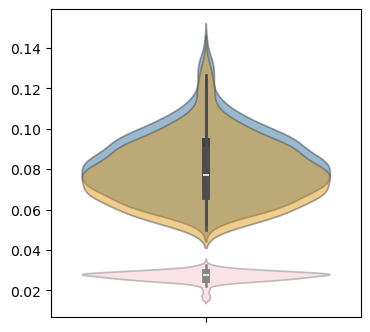

In [122]:
sns.violinplot(mae, alpha=0.5)
sns.violinplot(mae_true, alpha=0.5, color="orange")
sns.violinplot(mae_true_rand, alpha=0.5, color="pink")

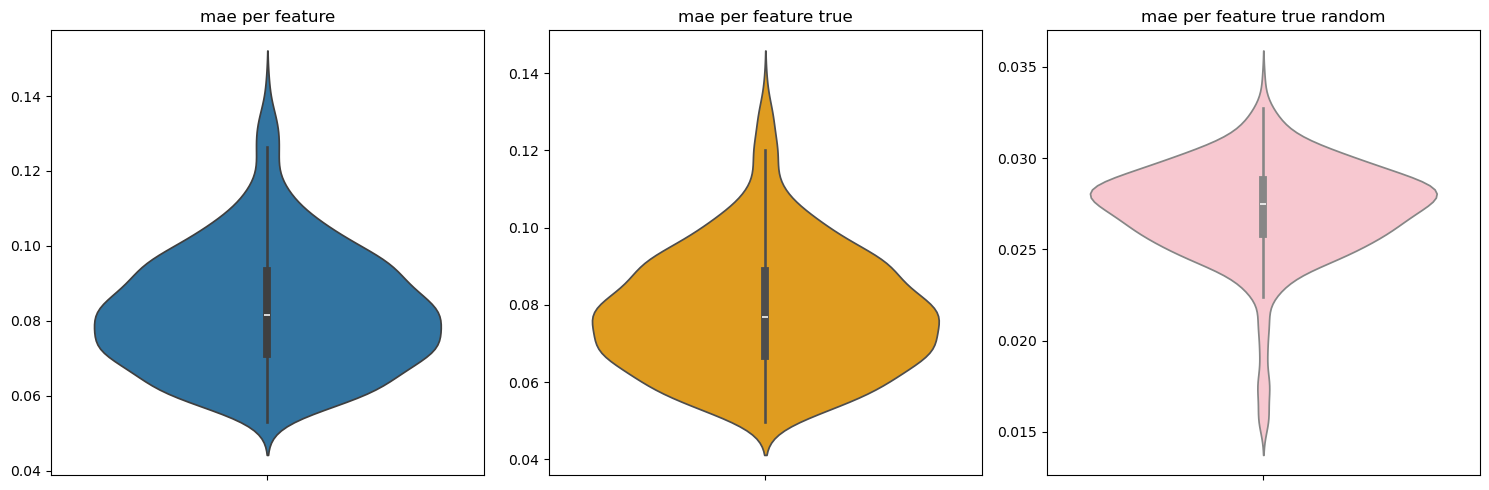

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.violinplot(mae, ax=axes[0])
axes[0].set_title("mae per feature")

sns.violinplot(mae_true, ax=axes[1], color="orange")
axes[1].set_title("mae per feature true")

sns.violinplot(mae_true_rand, color="pink")
axes[2].set_title("mae per feature true random")

plt.tight_layout()
plt.show()

In [124]:
# create AnnData object of autoencoder data
aedata = ad.AnnData(X=ae_imp)
aedata.obs = adata.obs.copy()
aedata.var = adata.var.copy()

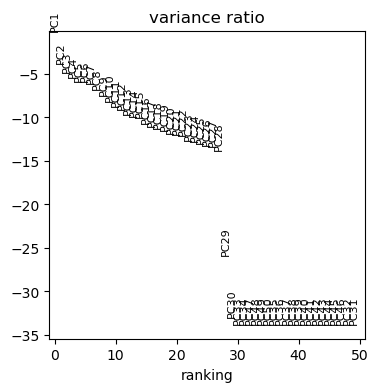

In [125]:
# pca
sc.tl.pca(aedata)
sc.pl.pca_variance_ratio(aedata, n_pcs=50, log=True)

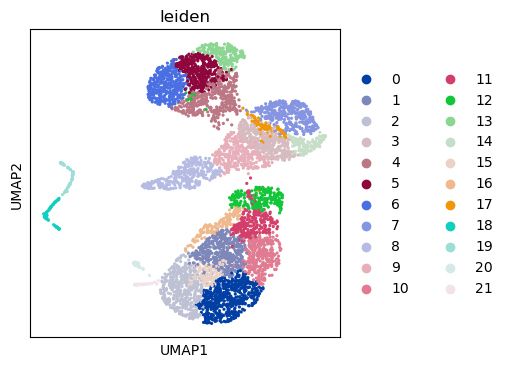

In [126]:
# umap
sc.pp.neighbors(aedata)
sc.tl.leiden(aedata)
sc.tl.umap(aedata)
sc.pl.umap(aedata, color="leiden")

In [127]:
xdata.obs["source"] = "base imputation"
aedata.obs["source"] = "autoencoder"

In [128]:
cdata = xdata.concatenate(aedata, batch_key=None)
cdata.shape, 5618*2

((11236, 670), 11236)

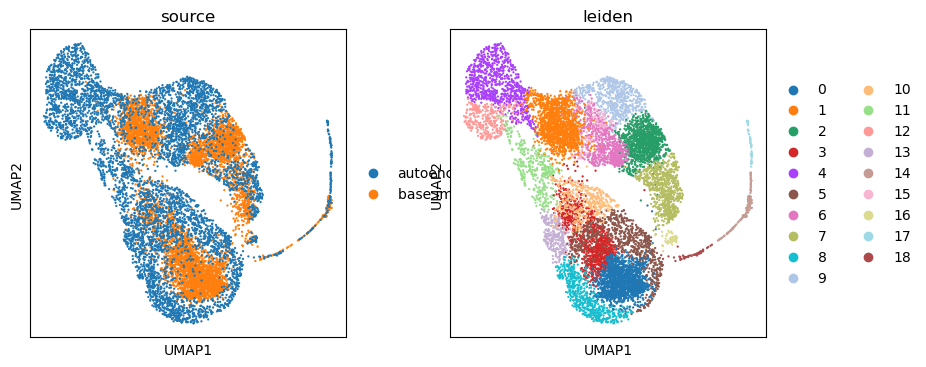

In [129]:
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(cdata, color=["source", "leiden"])

2025-10-20 00:23:40,861 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-20 00:23:43,604 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-20 00:23:43,726 - harmonypy - INFO - Iteration 1 of 20
2025-10-20 00:23:46,888 - harmonypy - INFO - Iteration 2 of 20
2025-10-20 00:23:50,051 - harmonypy - INFO - Iteration 3 of 20
2025-10-20 00:23:53,202 - harmonypy - INFO - Iteration 4 of 20
2025-10-20 00:23:56,358 - harmonypy - INFO - Iteration 5 of 20
2025-10-20 00:23:59,513 - harmonypy - INFO - Iteration 6 of 20
2025-10-20 00:24:02,682 - harmonypy - INFO - Iteration 7 of 20
2025-10-20 00:24:04,060 - harmonypy - INFO - Iteration 8 of 20
2025-10-20 00:24:04,986 - harmonypy - INFO - Iteration 9 of 20
2025-10-20 00:24:05,911 - harmonypy - INFO - Iteration 10 of 20
2025-10-20 00:24:06,837 - harmonypy - INFO - Iteration 11 of 20
2025-10-20 00:24:07,761 - harmonypy - INFO - Iteration 12 of 20
2025-10-20 00:24:08,687 - harmonypy - INFO - Iteration 13 of

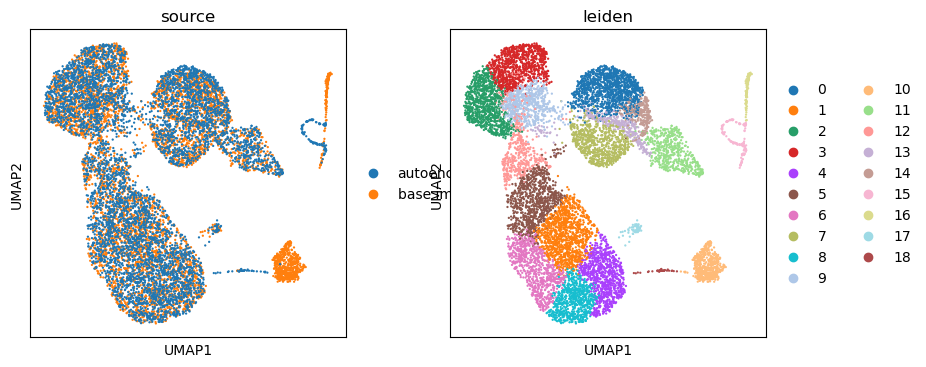

In [130]:
sc.external.pp.harmony_integrate(cdata, "source", max_iter_harmony=20)
sc.pp.neighbors(cdata, n_pcs=20, n_neighbors=20, use_rep="X_pca_harmony")
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata, color=["source", "leiden"])

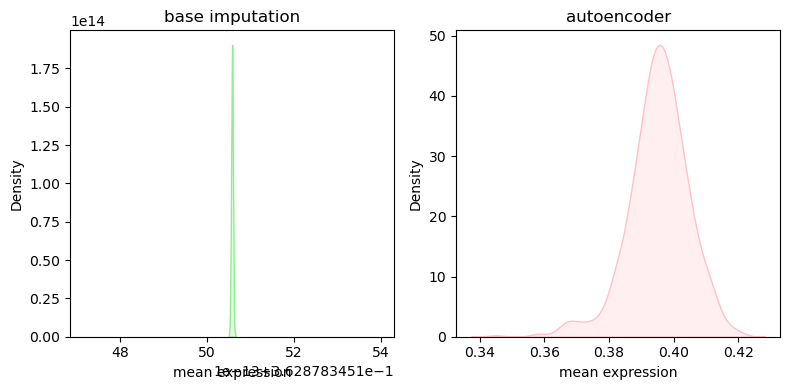

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.kdeplot(x=xdata.to_df().mean(), ax=axes[0], fill=True, color="lightgreen",)
axes[0].set_title("base imputation")
axes[0].set_xlabel("mean expression")

sns.kdeplot(x=aedata.to_df().mean(), ax=axes[1], fill=True, color="pink")
axes[1].set_title("autoencoder")
axes[1].set_xlabel("mean expression")
plt.tight_layout()

In [132]:
# combine the means into one DataFrame
combined = pd.concat([
    pd.DataFrame({"means": xdata.to_df().mean(), "source": "base imputation"}),
    pd.DataFrame({"means": aedata.to_df().mean(), "source": "autoencoder"})
])

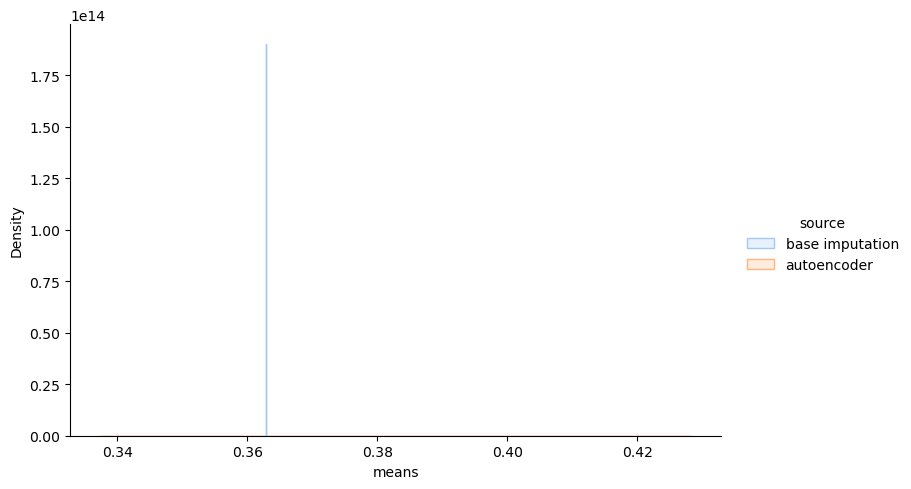

In [133]:
# plot overlapping KDEs
sns.displot(data=combined, x="means", hue="source", kind="kde", fill=True, palette="pastel", aspect=1.5, height=5, common_norm=False)

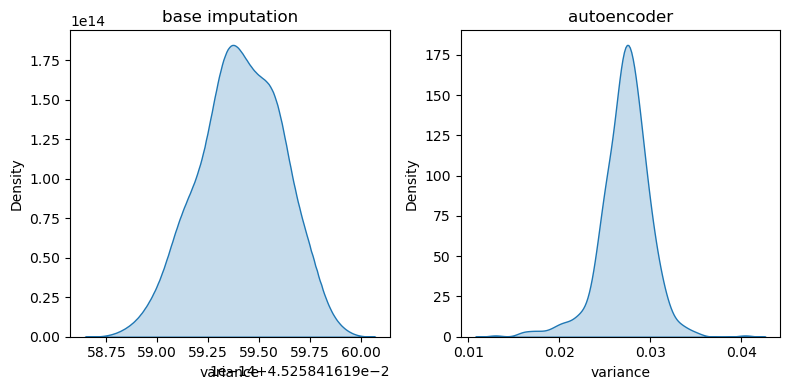

In [134]:
# plot distribution of feature variances
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

feat_var = xdata.to_df().var()
sns.kdeplot(feat_var, ax=axes[0], fill=True)
axes[0].set_title("base imputation")
axes[0].set_xlabel("variance")

feat_var = aedata.to_df().var()
sns.kdeplot(feat_var, ax=axes[1], fill=True)
axes[1].set_title("autoencoder")
axes[1].set_xlabel("variance")

plt.tight_layout()

In [135]:
sc.tl.rank_genes_groups(cdata, groupby="source")
top_genes = cdata.uns["rank_genes_groups"]["names"]["base imputation"][:20]
top_genes

array(['ENSG00000283098', 'ADGRB1', 'HOOK2', 'NOL4L', 'BAIAP2', 'PCDHGB2',
       'PCDHGB1', 'PCDHGA3', 'RAI1', 'PCDHGA2', 'PCDHGA5', 'LINGO1',
       'ENSG00000196498.14', 'EBF3', 'RBFOX3', 'PCDHGA4', 'PPP2R2C',
       'ATP2B2', 'PCDHGA1', 'CSMD1'], dtype=object)

base imputation


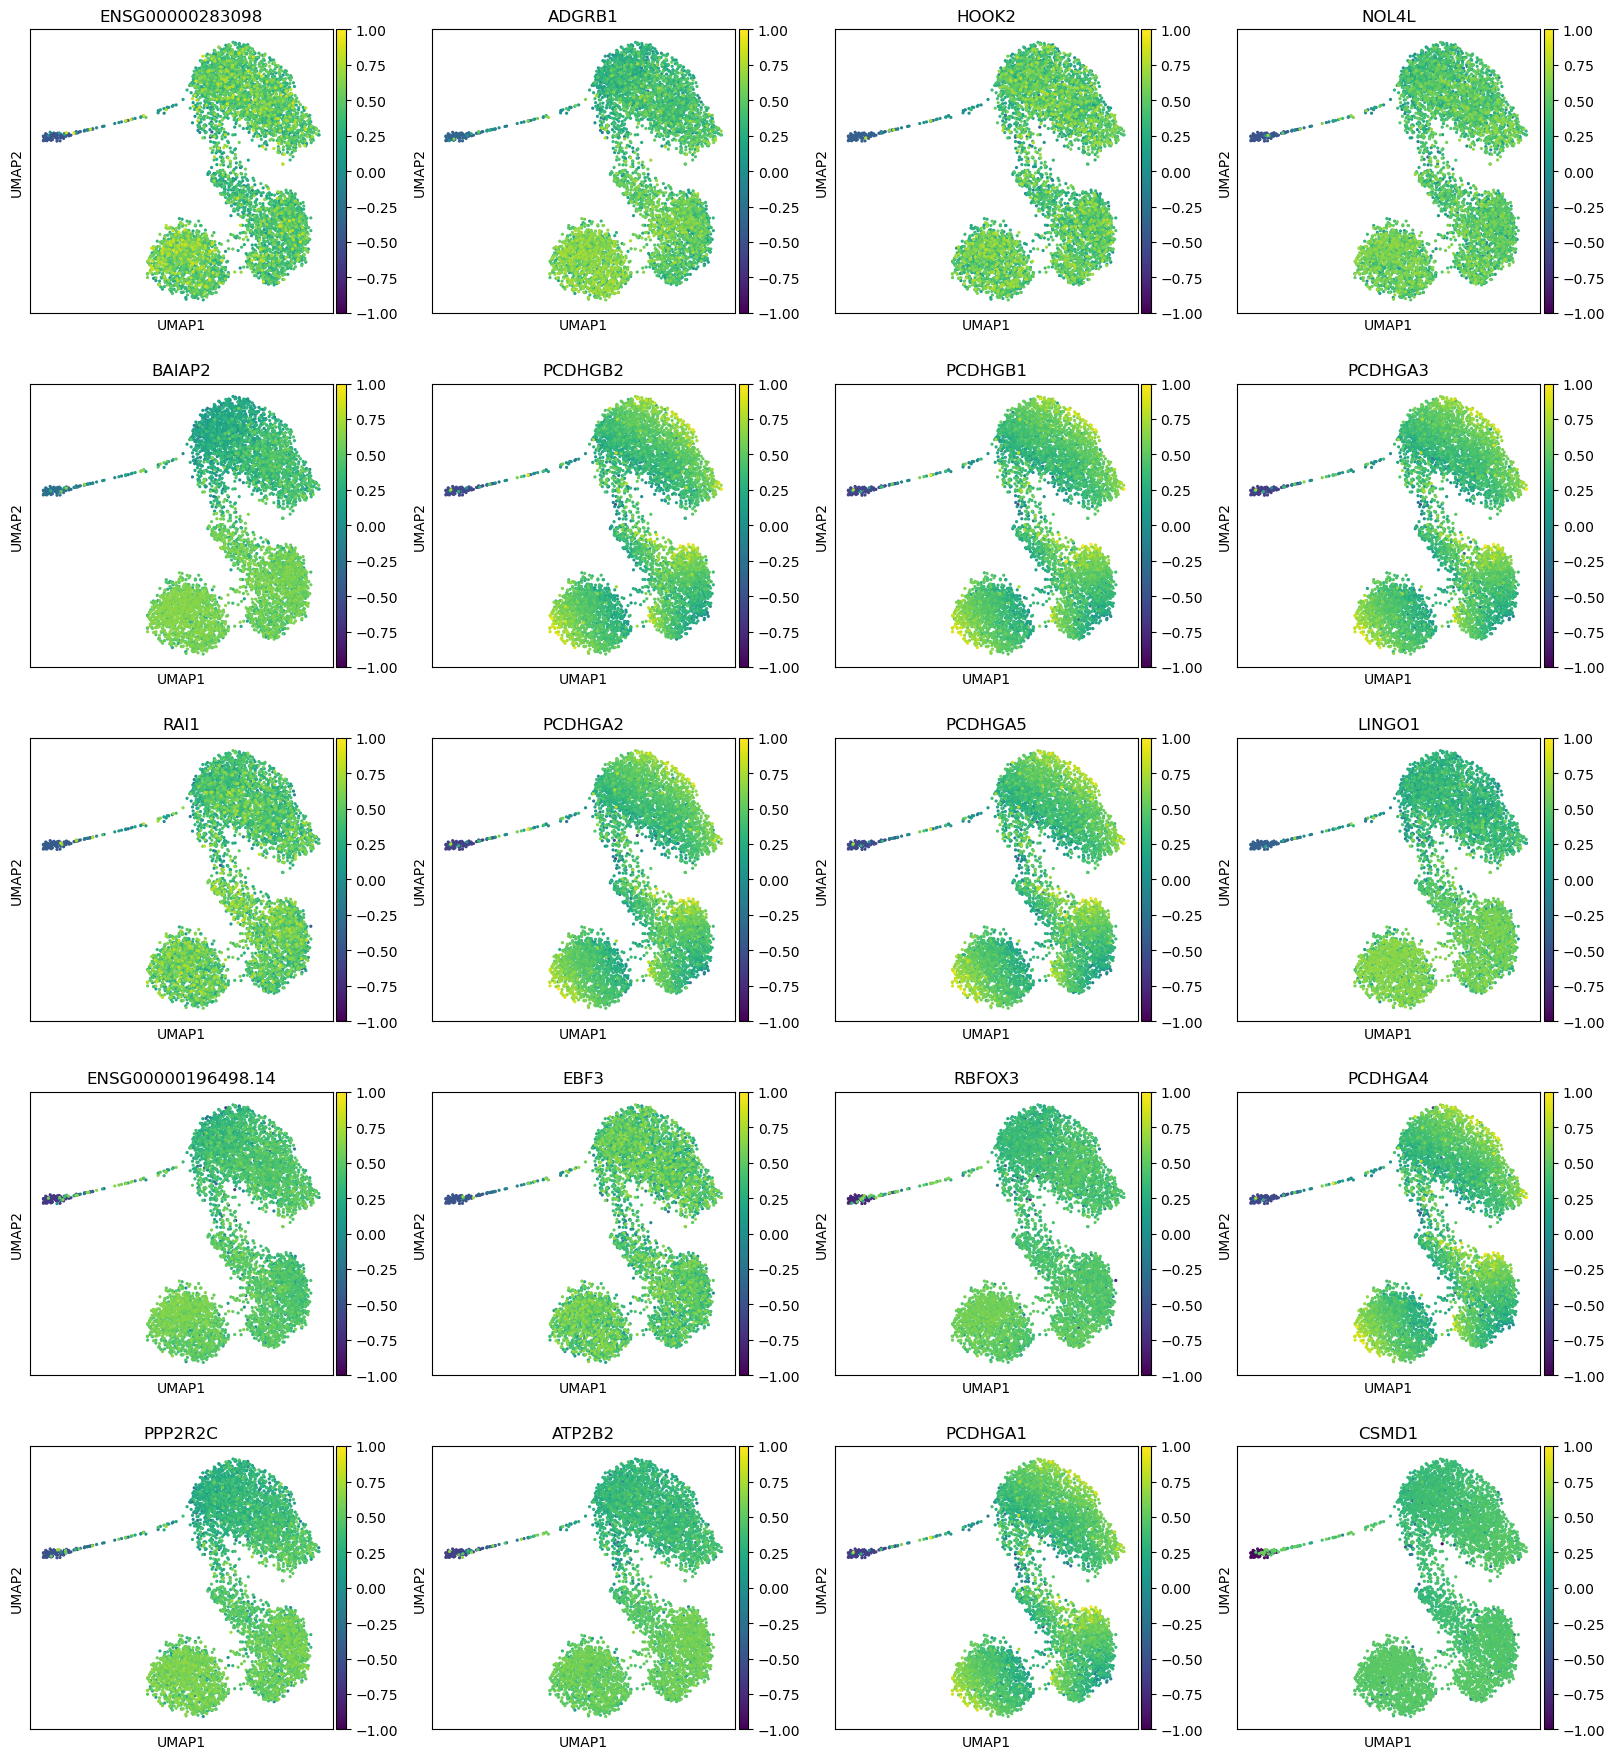

In [136]:
print("base imputation")
sc.pl.umap(xdata, color=top_genes, ncols=4, vmin=-1, vmax=1)

In [137]:
sc.tl.rank_genes_groups(cdata, groupby="source")
top_genes = cdata.uns["rank_genes_groups"]["names"]["autoencoder"][:20]
top_genes

array(['ENSG00000196367.15', 'LNC-LBCS', 'RGS12', 'GLI3', 'HLCS', 'OBSCN',
       'ERICH1', 'ENSG00000285733', 'ENSG00000153093.21', 'GPHN',
       'OTUD7A', 'ZBTB7C', 'CLYBL', 'SCUBE1', 'AGPAT3', 'FBRSL1', 'GLI2',
       'IFT140', 'SFMBT2', 'SHISA6'], dtype=object)

autoencoder


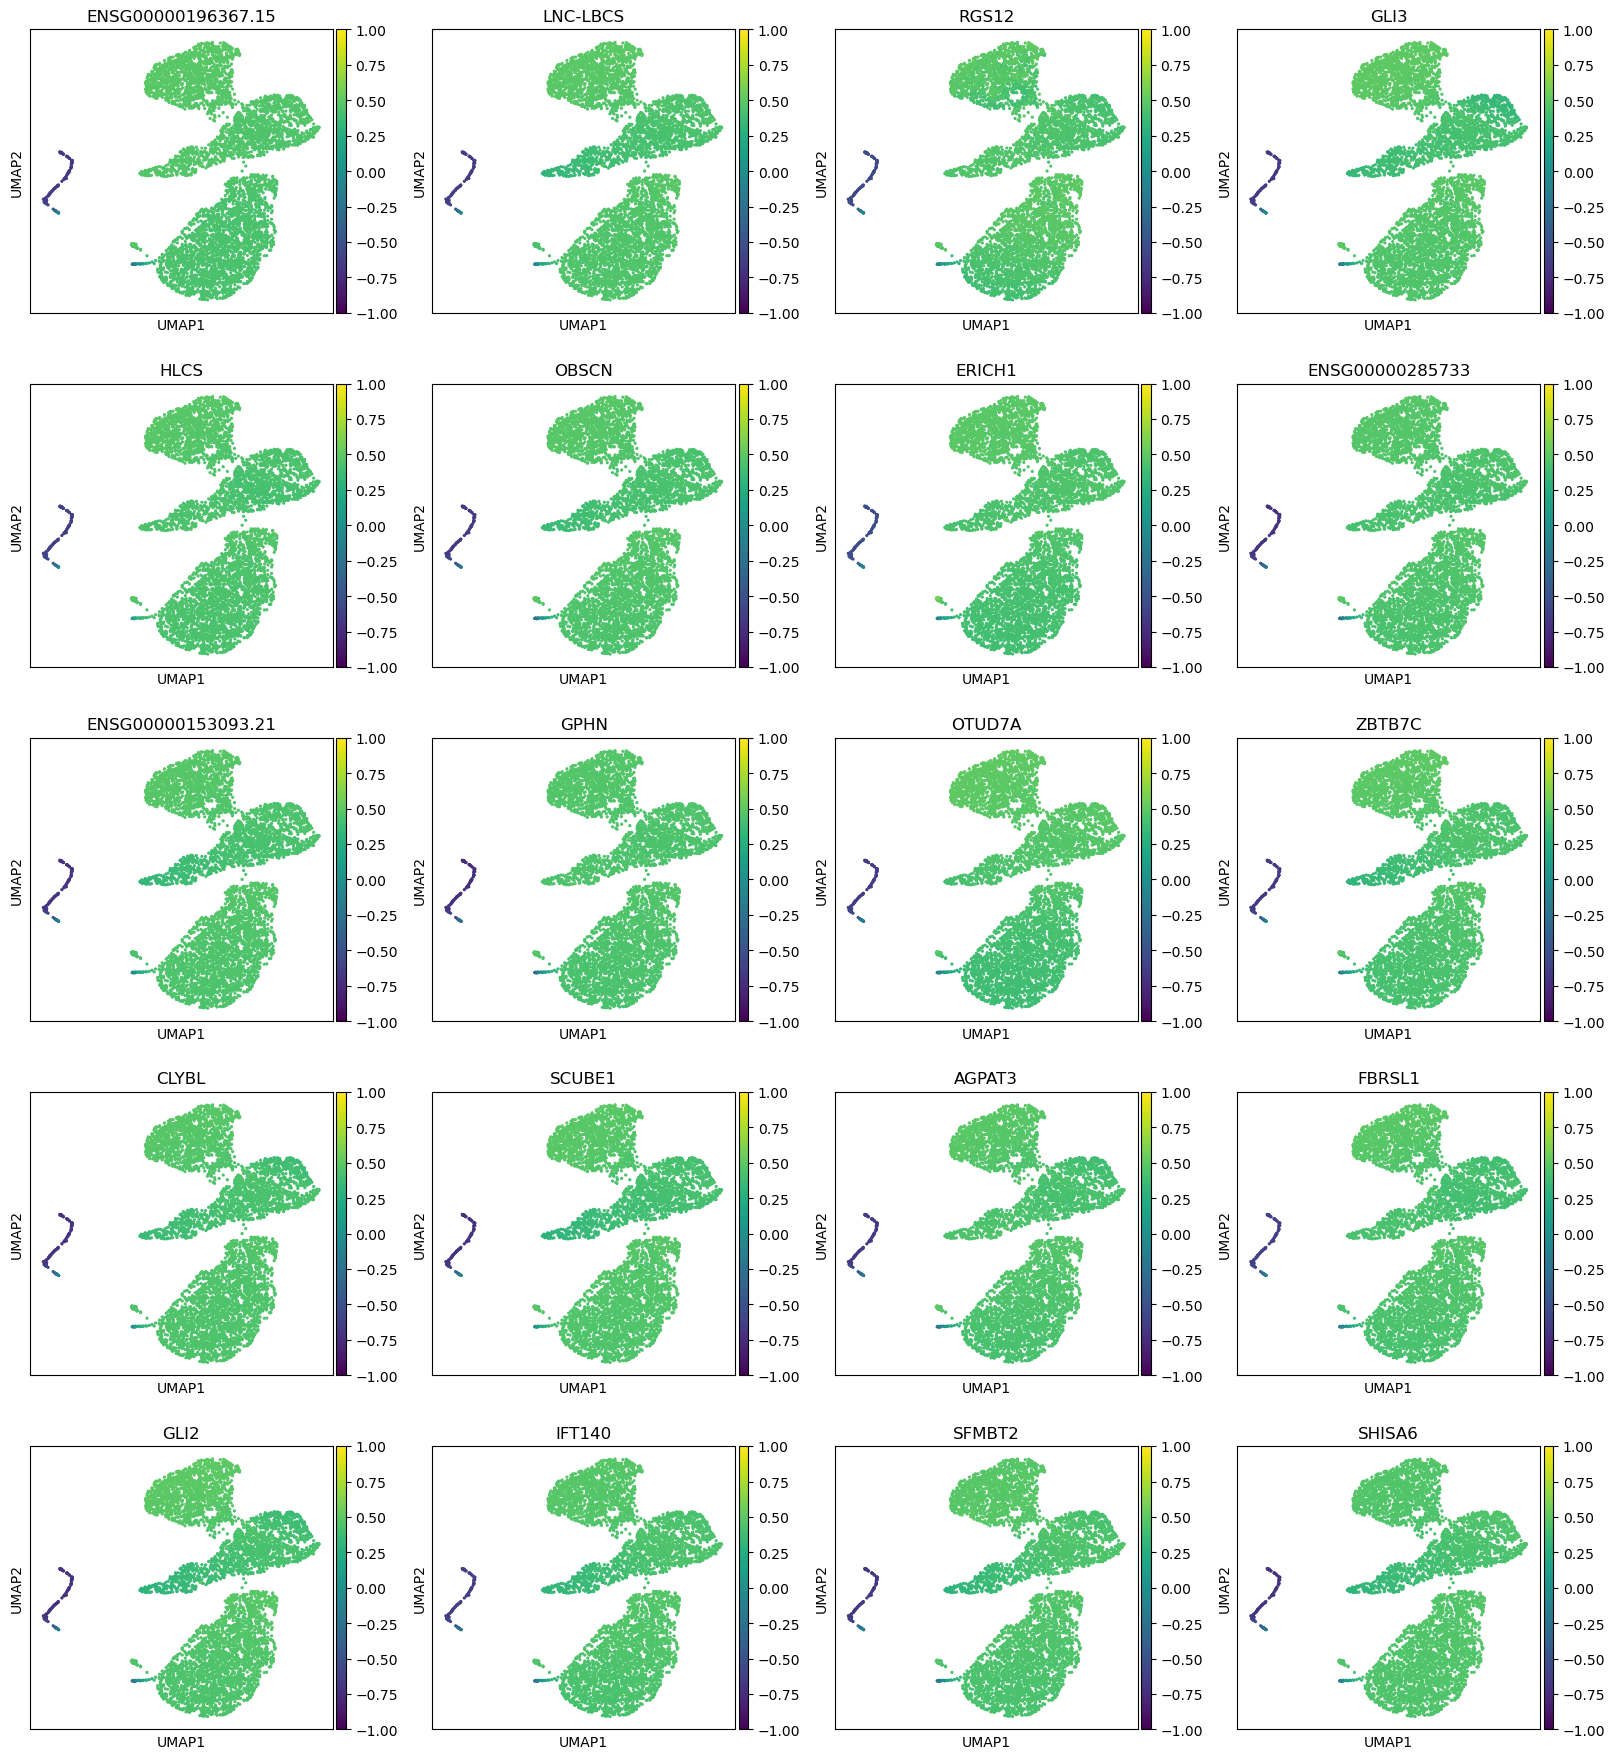

In [138]:
print("autoencoder")
sc.pl.umap(aedata, color=top_genes, ncols=4, vmin=-1, vmax=1)

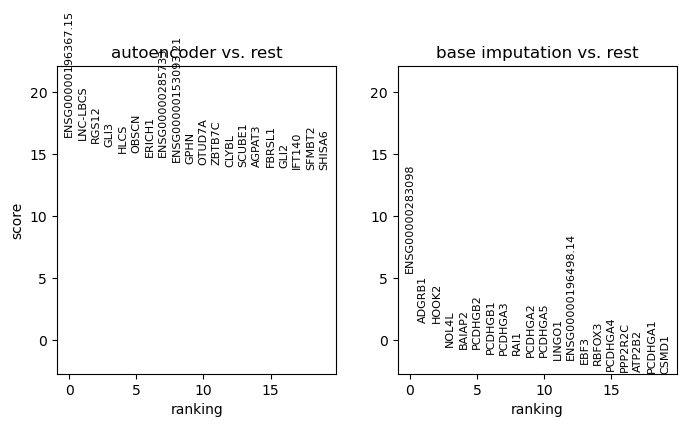

In [139]:
# top 20 gene expressions
sc.pl.rank_genes_groups(cdata, n_genes=20)

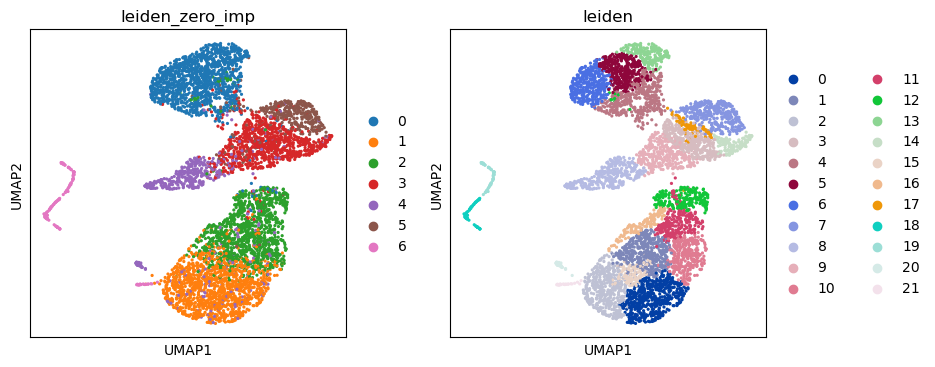

In [140]:
# copy leiden labels
aedata.obs["leiden_zero_imp"] = zdata.obs["leiden"].values

# plot umap with transferred leiden clusters
sc.pl.umap(aedata, color=["leiden_zero_imp", "leiden"])

In [141]:
plot_genes = ['CUX2','ADARB2','MBP'] # 'RORB', 'TLE4','GAD2','LHX6','AQP4','CSF1R' not in the 670 features

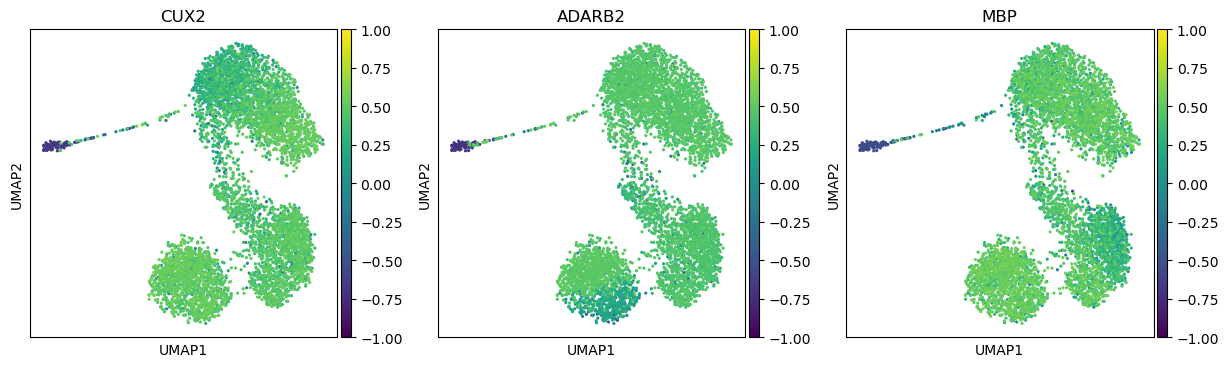

In [142]:
sc.pl.umap(xdata, color=plot_genes, ncols=3, vmin=-1, vmax=1)

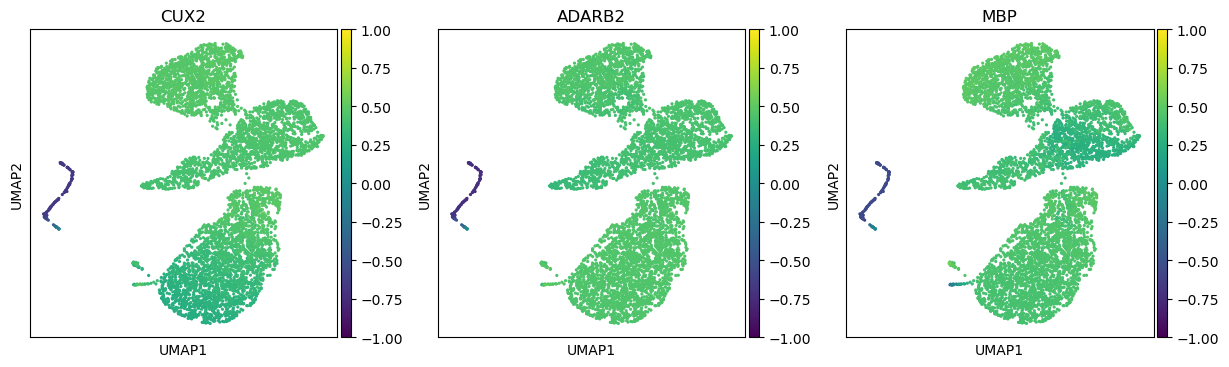

In [143]:
sc.pl.umap(aedata, color=plot_genes, ncols=3, vmin=-1, vmax=1)

In [144]:
# aedata.write_h5ad("mcg_210505_5618x670_autoencoder_zero_imputation_mae.h5ad")
# aedata.write_h5ad("mcg_210505_5618x670_autoencoder_mean_imputation_mae.h5ad")
aedata.write_h5ad("mcg_210505_5618x670_autoencoder_knn_imputation_mae.h5ad")